# Кейс 2:
## Умови:

Продукт - мобільний додаток з планом харчування та планом тренувань. Модель монетизації - передплата, оплата 9.99 USD на тиждень (7 днів). За посиланням нижче вивантаження з бази даних щодо оформлення передплат та наступних оплат. Кожен рядок є окремою подією. Завдання побудоване в таким чином, щоб перевірити розуміння принципів unit-економіки підприємства. Подавати інформацію слід так, ніби ви її презентуєте людині, далекій від аналітики, а ваша мета - донести ідею.

***Завдання:***

1. Необхідно розрахувати поточний LTV користувача, використовуючи когортний аналіз (cohorting event - оформлення першого платежу, когорта є кількістю можливих операцій) на 1.5 місяці (6 платежів).
2. Спрогнозувати LTV користувача на 2, 5, 6 місяців.
3. Розрахувати прогнозований ROAS на 6 тижнів і півроку, якщо  ціна залучення користувача, що оформлює передплату - 30 USD

### Опис даних:

Product_id - тип передплати, ми маємо за умовою 9.99 на тиждень.

Quantity - кількість дублів операції

Purchase_date - дата операції

Сurrent_date - дата на момент розрахунку

Subscription_date - дата оформлення передплати (перша оплата)

User_id - унікальний код конкретного користувача

Cohort - номер тижня, коли були залучені користувачі

In [1]:
# імпортуємо бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Відкриємо та проаналізуємо наш датасет:

In [2]:
df = pd.read_excel('test_case.xlsx')
df

,product_id,quantity,purchase_date,current_date,subscription_date,user_id,Cohort
0,1week_9.99_USD_subscription,1,2021-02-19,2021-02-21,2021-02-19,9484222,1
1,1week_9.99_USD_subscription,1,2021-02-17,2021-02-21,2021-02-17,9422402,1
2,1week_9.99_USD_subscription,1,2021-02-18,2021-02-21,2021-02-18,4997991,1
3,1week_9.99_USD_subscription,1,2021-02-18,2021-02-21,2021-02-18,9455582,1
4,1week_9.99_USD_subscription,1,2021-02-16,2021-02-21,2021-01-26,8803657,4
...,...,...,...,...,...,...,...
51141,1week_9.99_USD_subscription,1,2021-02-02,2021-02-21,2021-02-02,8995745,3
51142,1week_9.99_USD_subscription,1,2021-01-12,2021-02-21,2021-01-12,8375739,6
51143,1week_9.99_USD_subscription,1,2021-01-30,2021-02-21,2021-01-16,8485273,6
51144,1week_9.99_USD_subscription,1,2021-02-03,2021-02-21,2021-01-12,8375118,6


Подивимось кількість унікальних значень для кожної колонки. Ця інформація буде нам корисна для подальшого аналізу.

In [3]:
print('кількість унікальних product_id = ', df['product_id'].nunique())
print('кількість унікальних quantity = ',df['quantity'].nunique())
print('кількість унікальних purchase_date = ',df['purchase_date'].nunique())
print('кількість унікальних current_date = ',df['current_date'].nunique())
print('кількість унікальних subscription_date = ',df['subscription_date'].nunique())
print('кількість унікальних user_id = ',df['user_id'].nunique())
print('кількість унікальних Cohort = ',df['Cohort'].nunique())

кількість унікальних product_id =  1
кількість унікальних quantity =  1
кількість унікальних purchase_date =  47
кількість унікальних current_date =  1
кількість унікальних subscription_date =  47
кількість унікальних user_id =  19536
кількість унікальних Cohort =  7


### Завдання 1:
*Необхідно розрахувати поточний LTV користувача, використовуючи когортний аналіз (cohorting event - оформлення першого платежу, когорта є кількістю можливих операцій) на 1.5 місяці (6 платежів).*


Для початку визначимо що таке LTV:

LTV (Customer Lifetime Value) -  показник суми грошей, яку користувач приносить в середньому протягом своєї взаємодії з продуктом.

У нашому випадку ми шукаємо LTV на 1,5 місяці, тому нам треба знайти середній дохід компанії від користувача за 6 тижнів.

Для пошуку LTV є декілька формул:

1)
$LTV = ARPU \frac{1}{Churn}$

**ARPU (Average Revenue Per User)** - показник, який вимірює середній дохід, який компанія отримує від кожного користувача протягом певного періоду часу.

$ARPU=  \frac{Загальний дохід}{Кількість користувачів}$

**Churn** - це коефіцієнт втрат, який вказує на ту частину клієнтів, яку компанія втрачає протягом певного періоду часу.

2)
**LTV = Subscription cost x Retention rate x Customer Lifetime Duration**

**Subscription cost** - вартість підписки (9,99$)

**Retention rate** - метрика, що вказує на те, який відсоток користувачів повертається до продукту через N-кількість днів після покупки першої підписки.

**Customer Lifetime Duration** - середня тривалість користування додатком 

3)
 $LTV =\sum_{t=1}^{n} (retention rate_{t} * Subscription cost)$

**Subscription cost** -  це вартість тижневої підписки

**retention rate_t** - це частка клієнтів що залишилась після t тижня (від загальної кількості)

**n** - це кількіст тижнів на які ми хочемо спрогнозувати LTV
 
 


Тепер повернемось до датасету. Для початку скопіюємо необхідні дані у нову таблицю, куди ми будемо додавати нові метрики. Оскільки 'product_id' та 'quantity' приймають лише одне значення, то ми їх відкинемо для більшої зручності. 'current_date' також всюди однакова, тому ми не будемо копіювати його у новий датасет, а просто запам'ятаємо, що current_date = 2021-02-21.

Створисо новий датасет з необхідними значеннями:

In [4]:
df_copy = df[['user_id', 'Cohort', 'subscription_date', 'purchase_date']].copy()
df_copy.head()

,user_id,Cohort,subscription_date,purchase_date
0,9484222,1,2021-02-19,2021-02-19
1,9422402,1,2021-02-17,2021-02-17
2,4997991,1,2021-02-18,2021-02-18
3,9455582,1,2021-02-18,2021-02-18
4,8803657,4,2021-01-26,2021-02-16


Отримали меньший датасет з якми буде зручно працювати у майбутньому. Оскільки ми будемо працювати з когортами та "юзерами", то нам вигідно згрупувати по когортам та "юзерам" і знайти для кожного користувача кількість операцій - тобто кількість куплених підписок ('number_of_subscriptions') 

In [5]:
group_data = df_copy.groupby(['Cohort','user_id']).size().reset_index(name='number_of_subscriptions')
group_data.head()

,Cohort,user_id,number_of_subscriptions
0,1,100404,1
1,1,103680,1
2,1,131706,1
3,1,188231,1
4,1,244520,1


Отримали зручне представлення по кожному користувачу з кількыстю проплачених ним підписок і номером когорти

Також додамо сумму грошей, яку користувач витратив у додатку (profit). Вона рахується як кількість куплених підписок * вартість підписки (9,99$)

In [6]:
group_data['profit'] = group_data['number_of_subscriptions'] * 9.99
group_data

,Cohort,user_id,number_of_subscriptions,profit
0,1,100404,1,9.99
1,1,103680,1,9.99
2,1,131706,1,9.99
3,1,188231,1,9.99
4,1,244520,1,9.99
...,...,...,...,...
19531,7,8286459,1,9.99
19532,7,8426953,6,59.94
19533,7,8466455,6,59.94
19534,7,8808750,2,19.98


Отже ми тепер знаємо скільки кожен користувач витратив за весь час користування додатком. Тепер знайдемо середнє значення витрачених грошей одним користувачем по когортам (ARPU).

ARPU (Average Revenue Per User) - показник, який вимірює середній дохід, який компанія отримує від кожного користувача протягом певного періоду часу.

***ARPU= Загальний дохід / Кількість користувачів***

In [7]:
for i in range(7):
    sum = group_data[group_data['Cohort']==i+1]['profit'].sum()
    count  = group_data[group_data['Cohort']==i+1]['user_id'].count()
    print('середній профіт з користувача ', i+1, ' когорти = ',sum/count)

середній профіт з користувача  1  когорти =  9.989999999999998
середній профіт з користувача  2  когорти =  16.058720930232557
середній профіт з користувача  3  когорти =  21.828720166032518
середній профіт з користувача  4  когорти =  27.73224
середній профіт з користувача  5  когорти =  33.7779952052742
середній профіт з користувача  6  когорти =  39.31462831858407
середній профіт з користувача  7  когорти =  45.40335018963337


Знайдемо частку користувачів, що перестають купувати підписку після певного тижня (відток користувачі).
Для пошуку відтоку користувачів, я буду знаходити кількість користувачів які оформили підписку на певний тиждень і мали можливість оформити її на наступний тиждень (тобто, якщо користувач прийшов тиждень тому або менше, то він фізично б не зміг купити другу підписку, тому ми його не враховуємо). Потім я знайду з них кількість тих, хто відмовився від підписки (купив на цей місяць, але не купив на наступний) після певного тижня. Відношення тих хто не купив наступну підписку до загальної кількості людей, що мали цю підписку і буде часткою відтоку.

In [8]:
churn = []
for i in range (6):
    x = group_data[(group_data['Cohort']>i+1) & (group_data['number_of_subscriptions']>=i+1)]['user_id'].count() #кількість користувачів, що взяли підписку і-й раз і мали змогу її продовжити
    y = group_data[(group_data['Cohort']>i+1) & (group_data['number_of_subscriptions']==i+1)]['user_id'].count() #кількість користувачів, що перестало купувати підписку після і-го тижня
    churn.append(y/x)
    print('Частка втрачених користувачів після ', i+1, ' тижня підписки = ', y/x) 

Частка втрачених користувачів після  1  тижня підписки =  0.2611868868150275
Частка втрачених користувачів після  2  тижня підписки =  0.2024575213593165
Частка втрачених користувачів після  3  тижня підписки =  0.18910719445247037
Частка втрачених користувачів після  4  тижня підписки =  0.19339733083586982
Частка втрачених користувачів після  5  тижня підписки =  0.20198675496688742
Частка втрачених користувачів після  6  тижня підписки =  0.47058823529411764


Як бачимо приблизно 20% користувачів не продовжують підписку після її завершення. Проте, після 6 тижня майже половина користувачів не продовжують підписку. Отже, можна зробити висновок, що більшість юзерів користуються додатком в середньому до 6 тижнів.

Але для підрахунку LTV нам необхідна метрика, що дорівнює відсотку користувачів (від початкової кількості), що залишились по кожному тижню. Тому знайдемо це значення віднявши частку втрачених користувачів від 1, а потім помноживши на частку юзерів, що залишились на минулому тижні .

In [9]:
# знайдемо частку користувачів, що продовжили підписку, за кожним тижнем як частку від загальної кількості користувачів
retention_rate = [0] * (len(churn)+1)    
retention_rate[0] = 1

for i in range(1, len(churn)+1):
    retention_rate[i] = (1-churn[i-1]) * retention_rate[i - 1]

Виведемо retention_rate, щоб перевірити правильність обчислень

In [10]:
print(retention_rate)

[1, 0.7388131131849724, 0.5892348415417827, 0.4778062937841703, 0.38539983190973226, 0.30755417049750156, 0.1628227961457361]


Отже, першиу підписку купує 100% користувачів, другу 74%, третю 58% і так далі. (відсоток рахується від кількіості користувачів що оформили першу підписку)

Створимо функцію яка буде обраховувати  LTV за заданий проміжок часу. Скористаємось формулою:

 $LTV =\sum_{t=1}^{n} ( retention rate_{t} * Subscription cost)) $

In [11]:
def ltv (weeks, retention_rate, subscription_cost):
    sum_retention_rate = np.sum(retention_rate[:weeks])
    return sum_retention_rate*subscription_cost

Функцыя ***ltv***  приймає три параметри:

***weeks*** - кількість тижнів за які ми рахуємо LTV

***retention_rate*** - масив з відсотками користувачів які продовжують підписку (по тижням в десятковому вигляді)

**subscription_cost** - ціна підписки на тиждень

Функція повертає значення LTV за заданий час



Отже, отримємо відповідь на перше завдання, викликавши функцію для обрахунку LTV

In [12]:
ltv6 = ltv(6,retention_rate,9.99)
print("LTV на 1,5 місяці = ", ltv6)

LTV на 1,5 місяці =  34.953094426672415


#### Отже, отримали значення LTV = 34.95$

Можемо порівняти отримане значення з середнім профітом додатку від користувачів 6 когорти (які почали користуватися 6 тижнів тому). Знайдемо середнє значення профіту 6 кагорти:

In [13]:
group_data[group_data['Cohort']==6]['profit'].mean()

39.31462831858407

Дійсно, отримали доволі схожі значення, що підтверджує правильність обрахунку LTV , отже LTV на 6 місяців  складає 34.95$

## Завдання 2:

 *Спрогнозувати LTV користувача на 2, 5, 6 місяців.*

 щоб спрогнозувати LTV ми маємо спрогнозувати яка частка клієнтів залишиться через 8, 20 та 24 тижні. Ми маємо значення retention_rate з 1 по 7 тиждень. Пошукаємо залежність цих значень для майбутнього прогнозування:



Дивлячись на значення retention_rate, спадає на думку провести дослідження на експоненсійну залежність значень. Спробуємо знайти експоненсіальну залежність цих даних (точки на графіку мають знаходитися поблизу лінії експоненсійного рівняння)

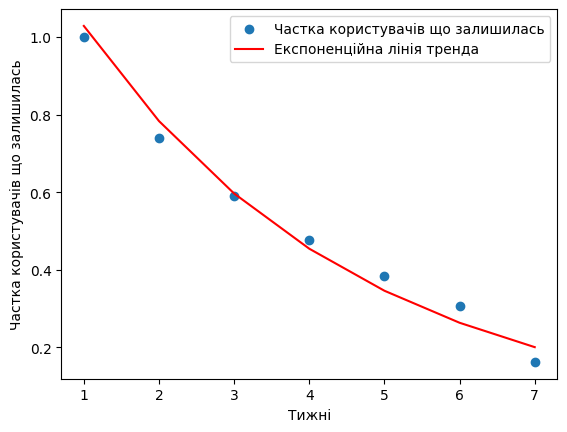

In [14]:

# додамо попередньо обрахованы дані
y_values = retention_rate

# Індекси тижнів
x_values = np.arange(1, len(y_values) + 1)

# Експоненційна лінія тренда
coefficients = np.polyfit(x_values, np.log(y_values), 1)
a, b = np.exp(coefficients[1]), coefficients[0]

# Побудуємо графік
plt.scatter(x_values, y_values, label='Частка користувачів що залишилась')
plt.plot(x_values, a * np.exp(b * x_values), label='Експоненційна лінія тренда', color='red')

plt.xlabel('Тижні')
plt.ylabel('Частка користувачів що залишилась')
plt.legend()
plt.show()

Дійсно, точки знаходяться близько до можливої лінії тренду. Тому, вважаю що частка користувачів, які щомісяця купують підписку змінюється експоненсійно.

Зробимо прогноз на 24 тижня (6 місяців):

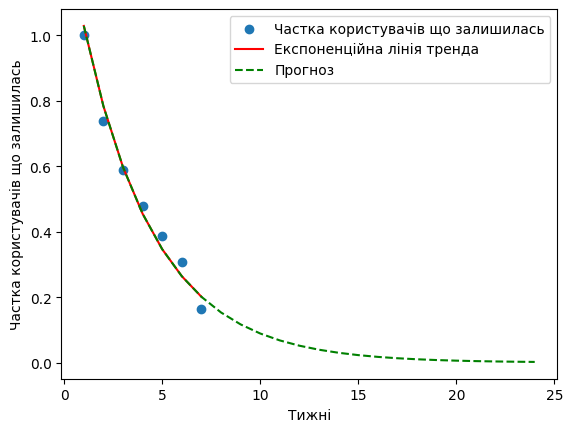

In [15]:
# Продовження лінії до x = 24
x_future = np.arange(1, 25)
y_future = a * np.exp(b * x_future)

# Побудуємо графік
plt.scatter(x_values, y_values, label='Частка користувачів що залишилась')
plt.plot(x_values, a * np.exp(b * x_values), label='Експоненційна лінія тренда', color='red')
plt.plot(x_future, y_future, label='Прогноз', linestyle='--', color='green')

plt.xlabel('Тижні')
plt.ylabel('Частка користувачів що залишилась')
plt.legend()
plt.show()

Знайдемо прогнозовані значення для наступних тижнів:

In [16]:
# Експоненційна лінія тренда
coefficients = np.polyfit(x_values, np.log(y_values), 1)
a, b = np.exp(coefficients[1]), coefficients[0]

# Прогноз для кожного x від 7 до 24
x_future = np.arange(7, 25)
y_future = a * np.exp(b * x_future)

# Вивід прогнозованих значень
for x, y in zip(x_future, y_future):
    retention_rate.append(y)
    print(f'Тиждень {x}, Прогноз = {y}')

Тиждень 7, Прогноз = 0.2008947633437059
Тиждень 8, Прогноз = 0.1530164074302116
Тиждень 9, Прогноз = 0.11654868724870665
Тиждень 10, Прогноз = 0.08877215670869874
Тиждень 11, Прогноз = 0.06761548321773324
Тиждень 12, Прогноз = 0.051500985672454334
Тиждень 13, Прогноз = 0.03922698469362895
Тиждень 14, Прогноз = 0.029878191806670895
Тиждень 15, Прогноз = 0.022757455170425184
Тиждень 16, Прогноз = 0.01733377204300162
Тиждень 17, Прогноз = 0.013202691205526867
Тиждень 18, Прогноз = 0.010056152500221282
Тиждень 19, Прогноз = 0.0076595143772940485
Тиждень 20, Прогноз = 0.005834056364467749
Тиждень 21, Прогноз = 0.004443651645159645
Тиждень 22, Прогноз = 0.0033846159018608457
Тиждень 23, Прогноз = 0.0025779754395481524
Тиждень 24, Прогноз = 0.001963578012872766


Звичайно, що під час прогнозування не було враховано багато факторів. До того ж даних лише за 6 тижнів замало, щоб зробити прогноз на пів року. Але враховуючи всі обставини у даній задачі, вважаю доречним прийняти такі прогнозовані дані.

Тепер маючи всі необхідні значення ми можемо зробити припущення про LTV користувача на 2, 5, 6 місяців. Вище вже була розроблена формула для підрахунку ltv. Скористаємось нею для пошуку значень

In [17]:
print('LTV на 2 місяці = ', ltv(8,retention_rate, 9.99))
print('LTV на 5 місяців = ',ltv(20,retention_rate, 9.99))
print('LTV на 6 місяців = ',ltv(24,retention_rate, 9.99))

LTV на 2 місяці =  38.586632845971934
LTV на 5 місяців =  44.75614198189694
LTV на 6 місяців =  44.918382572413776


Як можна помітити, LTV на 2 місяці не сильно відрізняється від LTV на 1,5 місяця. Так стається, тому що значна частина користувачів не продовжує підписку на додаток після пів року використання. Так само LTV на 5 та 6 місяців є дуже близькими за значенням, тому що дуже малий відсоток користувачів використовує додаток такий довгий термін. Тому на більшому часовому проміжку ми будемо отримувати дедалі ближчі один до одного значення.

**Отримані LTV:**

**LTV на 2 місяці =  38.586632845971934**

**LTV на 5 місяців =  44.75614198189694**

**LTV на 6 місяців =  44.918382572413776**

### Завдання 3:

**Розрахувати прогнозований ROAS на 6 тижнів і півроку, якщо  ціна залучення користувача, що оформлює передплату - 30 USD**

ROAS (Return on Advertising Spend) - це показник ефективності реклами, який визначає, наскільки ефективно витрати на рекламу генерують виручку.

***ROAS = Виручка від реклами / Витрати на рекламу***


У нашому випадку витрати на рекламу - це ціна залучення користувача, що становить 30$. Вона ніяк не залежить від часового проміжку

Виручка від реклами це і є наш показник LTV, який залежить від часового проміжку і який ми обраховували раніше

Отже, щоб знайати ROAS на 6 тижнів ми маємо знайти відношення LTV за 6 тижнів до ціни залучення користувача (30$). Аналогічні дії виконаємо для 6 місяців (24 тижні)

In [18]:
ltv_6 = ltv(6,retention_rate, 9.99)
ltv_24 = ltv(24,retention_rate, 9.99)
ROAS_6 = ltv_6 / 30
ROAS_24 = ltv_24 / 30
print('ROAS на 6 тижнів = ',ROAS_6)
print('ROAS на 6 місяців = ',ROAS_24)

ROAS на 6 тижнів =  1.1651031475557472
ROAS на 6 місяців =  1.4972794190804593


Ми отримали ROAS більший за 1, що означає, що реклама приносить доходу більше, ніж на неї було витрачено. ROAS = 1.165 означає що за кожні 100$ витрачених на рекламу, компаныя отримає 116 доларів через 6 місяців, а через пів року цей показник вже буде становити 149 доларів

**Отриманий результат:**

**ROAS на 6 тижнів =  1.1651031475557472**

**ROAS на 6 місяців =  1.4972794190804593**